In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from random import sample
from collections import defaultdict
from statistics import median
from pandarallel import pandarallel
import csv

#### Info Based

In [2]:
def iind(matrix, alpha = .5):
    p = alpha
    matrix = matrix[matrix.sum(axis = 1) > 0.0]
    s = matrix.values.sum()
    if s == 0:
        raise Exception('Sum of matrix is equal to 0')
    matrix = matrix / s
    m1 = matrix.sum(axis = 1)
    m2 = matrix.sum(axis = 0)
    outer_p = np.outer(m1, m2) 
    factor = 1 / (p-1)
    s = np.divide(np.power(matrix,p),np.power(outer_p,(p-1))).sum().sum()
    dividend = np.log(s)
    divisor = (np.log(np.sum(np.power(m2,(2-p)))))
    return dividend / divisor  

In [3]:
def leave_one_out(m_case, m_control, feature_subset, row_num):
    a = m_case.iloc[[row_num],feature_subset]
    b = m_control.iloc[:,feature_subset]
    partial_res = iind(a.append(b, ignore_index=True)) - iind(m_control.iloc[:,feature_subset])
    results = []

    for i, feature_num in enumerate(feature_subset):
        c = feature_subset.copy()
        c.remove(feature_num)
        a1 = m_case.iloc[[row_num], c]
        b1 = m_control.iloc[:, c]
        ind = iind(a1.append(b1, ignore_index=True)) - iind(m_control.iloc[:,c])
        results.append(ind)
    res = np.subtract(np.array([partial_res]),  np.array([results]))
    return res[0]


# sprawdzic czy sample losuje z powtorzeniami

In [4]:
def apply_iind(m_case, m_control, features_num, row_num, k):
    feature_subset = sample(range(1, features_num), k)    
    try:
        results = leave_one_out(m_case,m_control,feature_subset, row_num)
    except Exception as e:
        results = np.repeat(np.nan, k)

    return np.r_[np.array(feature_subset), results]

In [5]:
def plot_dict(d, labels, title=""):
    vals = []
    for k,v in d.items():
        vals.append((labels[k], v))
    vals = list(sorted(vals, key=lambda x: x[1], reverse=True))
    vals = list(zip(*vals))
    if len(vals) == 0:
        print("vals = '[]'")
        return
    x = list(vals[0])
    y = list(vals[1])  
#     print(y)
    plt.figure(figsize=(15,15))
    plt.bar(range(len(y)), y, align='center')
    plt.xticks(range(len(x)), x, rotation=90)
    plt.title(title)
    plt.show()
    return x, y

In [13]:
def get_score(feature_ind_vals, feature_ind_to_name, all_measurements, plot=True):
    feature_median = dict()
    for feature_ind, vals in feature_ind_vals.items():
        median = np.median(vals)
        if feature_ind not in all_measurements:
            all_measurements[feature_ind] = vals
        else:
            all_measurements[feature_ind].extend(vals)
        feature_median[feature_ind] = median            
            
    if plot:
        plot_dict(feature_median, feature_ind_to_name, "patient")
        
#     imp_list = list(map(lambda x: x[0], sorted(feature_median.items(), key=lambda x: x[1], reverse=True)))

    return feature_median


In [14]:
def func_(col, m, m2, features_count, i, k):
    return apply_iind(m, m2, features_count, i, k)

def collect_statistics(col, feature_ind_vals, k):
    control_res = col.tolist()
    for row_num, feature_num in enumerate(control_res):
        if row_num == k:
            break
        ind_val = control_res[row_num + k]
        if not np.isnan(ind_val):
            feature_ind_vals[int(feature_num)].append(ind_val)


In [15]:
m = pd.read_csv("male.csv")
m2 = pd.read_csv("female.csv")
iters = 100
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [16]:
df = pd.read_csv('data.csv')  
target = 'SEX'

#remove ABS from dataset
cols = [c for c in df.columns if c.lower()[:3] != 'abs']
df=df[cols]

labels = df[target].values
del df[target]
df = df[df.select_dtypes([np.number]).columns].dropna(axis='columns')
df

non_na_features = list(df)

m = m[non_na_features]
m2 = m2[non_na_features]

In [17]:
def save_feats(k, patient_id, feats):
    with open('k{}_patient{}.csv'.format(k,patient_ind),'w') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['feat','score'])
        for row in feats:
            csv_out.writerow(row)
            
def save_names(feats_to_names):
    with open('feat_to_name.csv', 'w') as f:
        w = csv.DictWriter(f, feats_to_names.keys())
        w.writeheader()
        w.writerow(feats_to_names)

In [18]:
def collect_ind_to_name(m):
    feature_ind_to_name = dict()
    for i, feature_name in enumerate(m.columns):
        feature_ind_to_name[i] = feature_name
    save_names(feature_ind_to_name)
    print(feature_ind_to_name)
    return feature_ind_to_name

{0: 'WBC', 1: 'LYC %', 2: 'MONO %', 3: 'BLAST %', 4: 'CD3-/CD5616+', 5: 'CD3+/CD5616-', 6: 'CD19+', 7: 'CD3+/CD69+', 8: 'CD3+/134+', 9: 'CD3+/HLA DR+', 10: 'CD3+/HLA DR-', 11: 'HLADR+/CD69+/CD3+/CD134-', 12: 'HLADR+/CD69-/CD3+/CD134+', 13: 'HLADR-/CD69+/CD3+/CD134+', 14: 'HLADR+/CD69+/CD3+/CD134+', 15: 'CD3+/CD80+', 16: 'CD3+/CD86+', 17: 'CD3+/CD80-', 18: 'CD3+/CD86-', 19: 'CD19+/CD80+', 20: 'CD19+/CD86+', 21: 'CD19+/CD80-', 22: 'CD19+/CD86-', 23: 'CD19+/CD80-/CD86-', 24: 'CD19+/CD80+/CD86+', 25: 'CD3+/CD80-/CD86-', 26: 'CD3+/CD80+/CD86+', 27: 'CD4+/CD45RA+', 28: 'CD4+/CD45RA-', 29: 'CD4+/CD45RO+', 30: 'CD4+/CD45RO-', 31: 'CD4+/CD27+', 32: 'CD4+ / CD27-', 33: 'CD8+/CD45RA+', 34: 'CD8+ / CD45RA-', 35: 'CD8+/CD45RO+', 36: 'CD8+ / CD45RO-', 37: 'CD8+ / CD27+', 38: 'CD8+ / CD27-', 39: 'CD45RA+ / CD45RO-', 40: 'CD45RA- / CD45RO+', 41: 'CD45RA+ / CD45RO+', 42: 'CD27+ / CD45RA+', 43: 'CD27- / CD45RA+ ', 44: 'CD27+ / CD45RO+', 45: 'CD27- / CD45RO+ ', 46: 'CD4+/CD45RA+/CD27-', 47: 'CD4+/CD27+/C

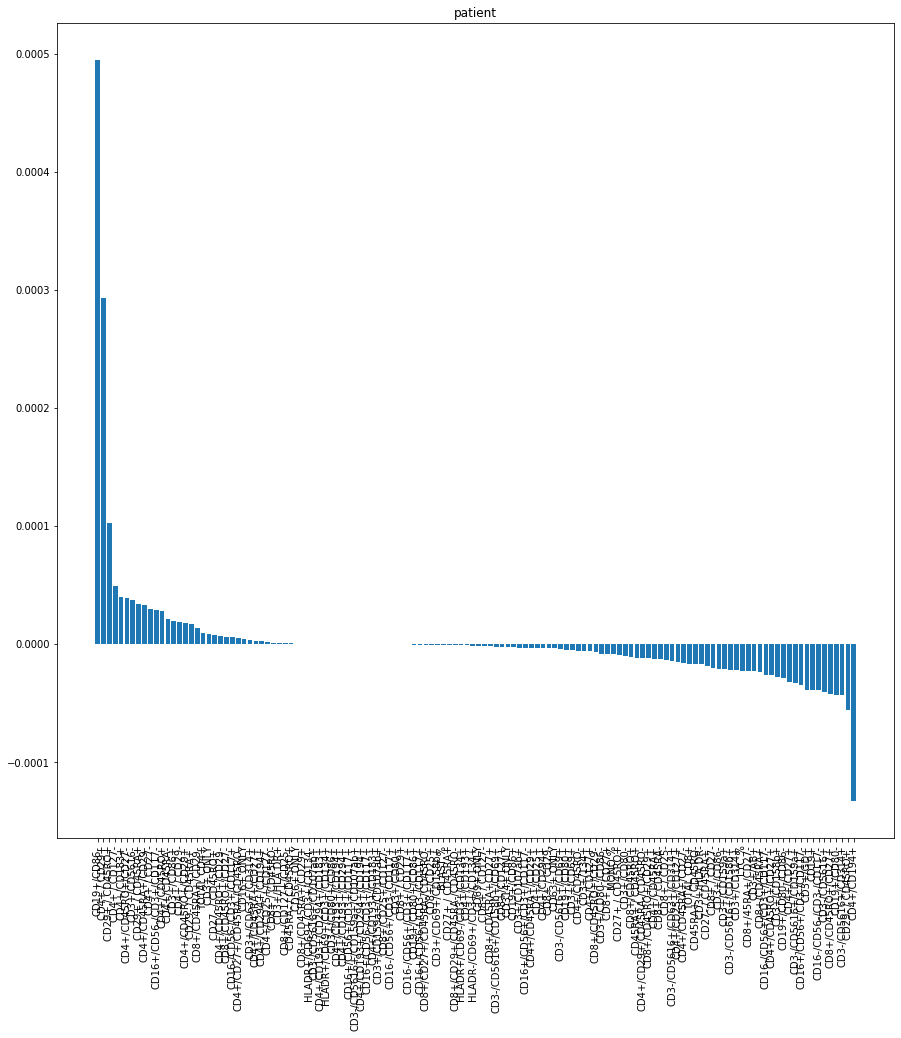

k =  15 , patient =  1


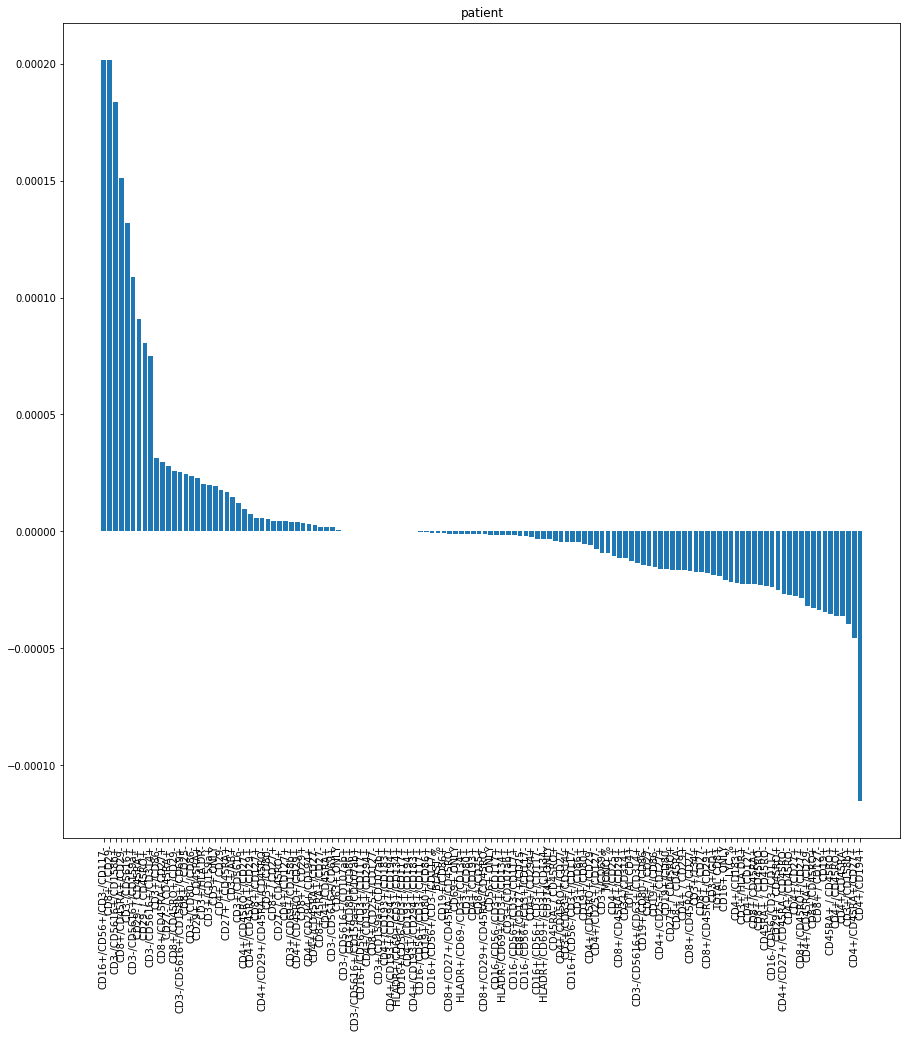

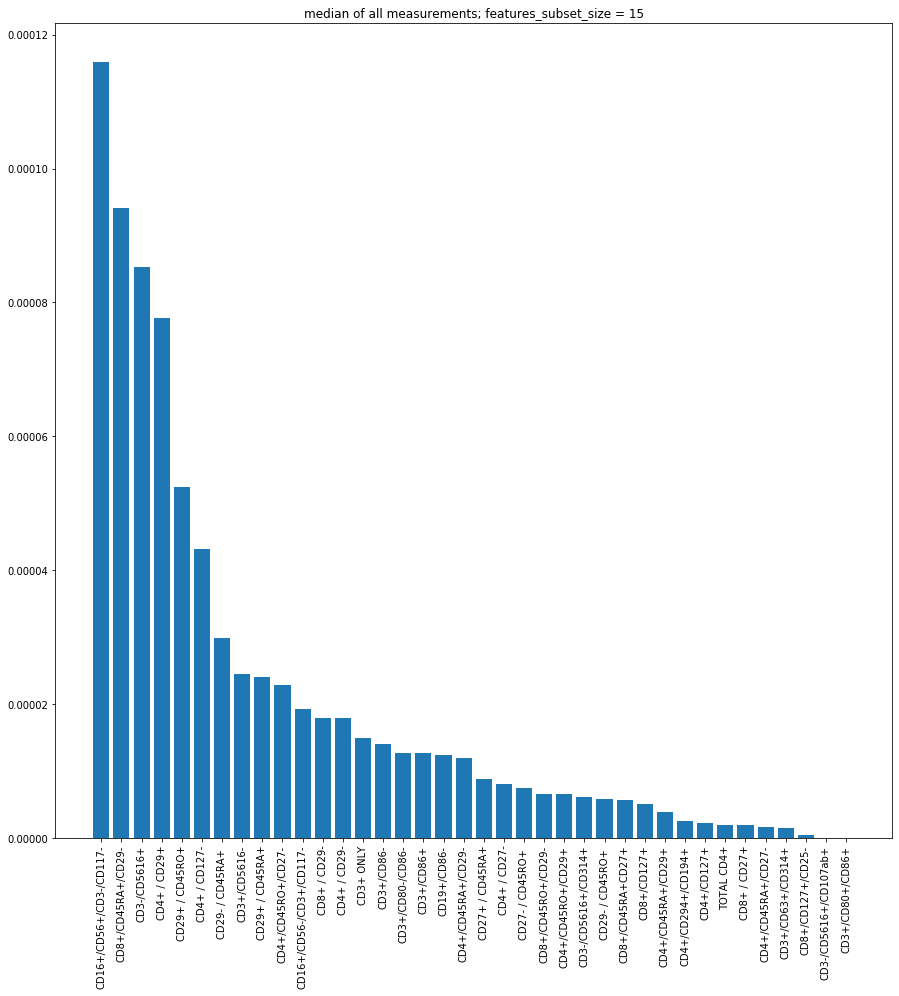

Selected features count:  19
['CD16+/CD56+/CD3-/CD117-', 'CD8+/CD45RA+/CD29-', 'CD3-/CD5616+', 'CD4+ / CD29+', 'CD29+ / CD45RO+', 'CD4+ / CD127-', 'CD29- / CD45RA+ ', 'CD3+/CD5616-', 'CD29+ / CD45RA+', 'CD4+/CD45RO+/CD27-', 'CD16+/CD56-/CD3+/CD117-', 'CD8+ / CD29-', 'CD4+ / CD29-', 'CD3+ ONLY', 'CD3+/CD86-', 'CD3+/CD80-/CD86-', 'CD3+/CD86+', 'CD19+/CD86-', 'CD4+/CD45RA+/CD29-']


In [20]:
# SUBSETS_SIZES = [5,10,20,30]
# PATIENTS_COUNT =  m.shape[0]
PATIENTS_COUNT = 2
SUBSETS_SIZES = [15]
FEATURES_COUNT = m.shape[1]
    
for features_subset_size in SUBSETS_SIZES:
    feature_ind_to_name = collect_ind_to_name(m)
    
    all_measurements = dict()
    importance_per_patient=dict()
    for patient_ind in range(PATIENTS_COUNT):
        # perform FS algorithm
        print("k = ", features_subset_size, ", patient = ", patient_ind)
        d = pd.DataFrame(-1, index=np.arange(2*features_subset_size), columns=[i+1 for i in range(iters)])
        d = d.transpose()
        d = d.parallel_apply(lambda col: func_(col, m, m2, FEATURES_COUNT, patient_ind, features_subset_size), axis=1)
        
        # collect results
        feature_ind_vals = defaultdict(list)
        d.apply(lambda row: collect_statistics(row,feature_ind_vals, features_subset_size));
        feature_median = get_score(feature_ind_vals, feature_ind_to_name, all_measurements)
        save_feats(features_subset_size, patient_ind, [(k,v) for k,v in feature_median.items()] )
        
    all_measurements_medians = dict()
    for feature_ind, vals in all_measurements.items():
        median = np.median(vals)
        if median > 0 and median != np.inf:
            all_measurements_medians[feature_ind] = median
    
    selected_fs, iind_val = plot_dict(all_measurements_medians, feature_ind_to_name, "median of all measurements; features_subset_size = " + str(features_subset_size))
    iind_median = np.median(iind_val)
    selected_fs_reduced = list(map(lambda x: x[0],filter(lambda x: x[1] >= iind_median, zip(selected_fs, iind_val))))
    
    if selected_fs_reduced:
        print("Selected features count: ", len(selected_fs_reduced))
        print(selected_fs_reduced)
#         df_selected = df[selected_fs_reduced]
#         test_classifiers(df_selected, labels)
    else:
        print("selected_fs_reduced was empty for k = ", features_subset_size)

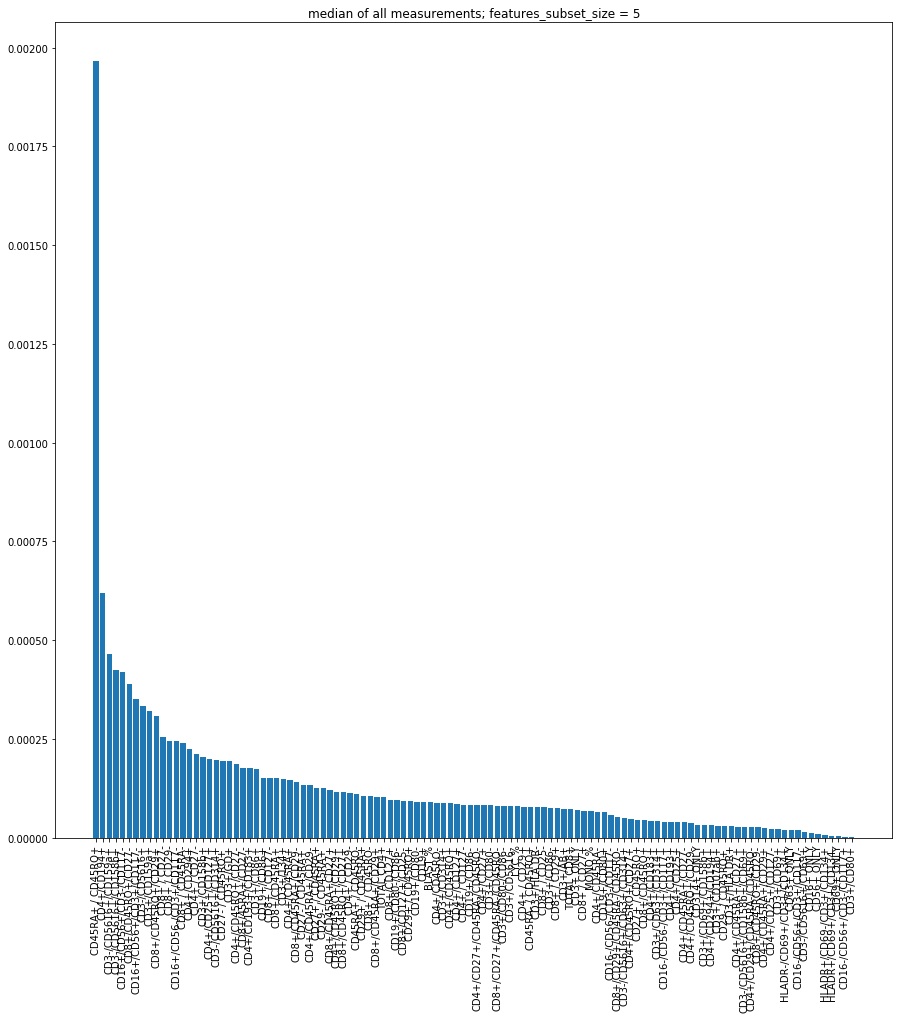

Selected features count:  10
['CD45RA+ / CD45RO+', 'CD4+/CD194+', 'CD3-/CD5616+/CD159a+', 'CD3-/CD5616+/CD158b+', 'CD16+/CD56+/CD3-/CD117-', 'CD8+/CD45RO+/CD27-', 'CD16+/CD56+/CD3+/CD117-', 'CD3-/CD5616+', 'CD3+/CD159a+', 'CD8+/CD45RO+/CD29+']


In [22]:
### READ RESULTS FROM PREVIOUS PROCESSINGS
k = 5
features_subset_size = k


feats = pd.read_csv('30_08_2020/feat_to_name.csv')
feats = feats.transpose()

all_feats_results=dict()
feature_ind_to_name = dict()


for i, f in enumerate(feats[0]):
    all_feats_results[i] = []
    feature_ind_to_name[i] = f

for patient_ind in range(18):
    patient_feat_results = pd.read_csv('30_08_2020/k{}_patient{}.csv'.format(k, patient_ind))
    for f, s in patient_feat_results.itertuples(index=False):
        all_feats_results[f].append(s)

all_measurements_medians = dict()
for k, v in all_feats_results.items():
    median = np.median(v)
    if median > 0 and median != np.inf and median != np.nan:
        all_measurements_medians[k] = median
selected_fs, iind_val = plot_dict(all_measurements_medians, feature_ind_to_name, "median of all measurements; features_subset_size = " + str(features_subset_size))
iind_median = np.median(iind_val)
    

selected_fs_reduced = list(map(lambda x: x[0],filter(lambda x: x[1] >= iind_median, zip(selected_fs, iind_val))))

selected_fs_reduced = selected_fs_reduced[:10]

if selected_fs_reduced:
    print("Selected features count: ", len(selected_fs_reduced))
    print(selected_fs_reduced)
#     df_selected = df[selected_fs_reduced]
#     test_classifiers(df_selected, labels)
else:
    print("selected_fs_reduced was empty for k = ", features_subset_size)
